In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import missingno as msno

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.ticker as mtick

# Data Exploration
## Read data

In [2]:
dt_2015 = pd.read_csv('./data/2015-building-energy-benchmarking.csv')
dt_2016 = pd.read_csv('./data/2016-building-energy-benchmarking.csv')

In [3]:
# Content
dt_2015.info()
dt_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

## Data exploration & cleaning
### Bulding types

Our focus here is on non-residential buildings (cf. OC)

In [4]:
from collections import Counter

## 2015

print(Counter(dt_2015['BuildingType']))
# Should work on non-residential data 

# Those are school
dt_2015[dt_2015['BuildingType'] == "SPS-District K-12"]

# Mainly commerce and others stuffs
dt_2015[dt_2015['BuildingType'] == "Nonresidential COS"]

# Mainly residentials
dt_2015[dt_2015['BuildingType'] == "Multifamily LR (1-4)"]
dt_2015[dt_2015['BuildingType'] == "Multifamily MR (5-9)"]
dt_2015[dt_2015['BuildingType'] == "Multifamily HR (10+)"]

# Campus
dt_2015[dt_2015['BuildingType'] == "Campus"]



## 2016
print(Counter(dt_2016['BuildingType']))
# On more category : Nonresidential WA (weird classification, might either be into campus cat., let's see later)
dt_2016[dt_2016['BuildingType'] == "Nonresidential WA"]
# Which is the University Memorial Wayne NE

# Building Type to Keep 
buildingType_to_keep = ['NonResidential','Nonresidential COS', 'Nonresidential WA' ,'SPS-District K-12', 'Campus']

Counter({'NonResidential': 1461, 'Multifamily LR (1-4)': 1029, 'Multifamily MR (5-9)': 554, 'Multifamily HR (10+)': 107, 'SPS-District K-12': 99, 'Nonresidential COS': 68, 'Campus': 22})
Counter({'NonResidential': 1460, 'Multifamily LR (1-4)': 1018, 'Multifamily MR (5-9)': 580, 'Multifamily HR (10+)': 110, 'SPS-District K-12': 98, 'Nonresidential COS': 85, 'Campus': 24, 'Nonresidential WA': 1})


### Dataset concatenation (2015/2016)

Both datasets have to be combined - both they don't have the same columns ... 


#### Buildings ID

Let's compare _building IDs_ among the two datasets (underlying question: it's fully redundant or is there new data in 2016 ?)

In [5]:
print('Intersection length between building ID in both list: {}'.\
    format(len(set(dt_2015['OSEBuildingID'].unique()).intersection(set(dt_2016['OSEBuildingID'].unique())))))

print('Differences length between building ID in both list: {}'.\
    format(len(set(dt_2015['OSEBuildingID'].unique())^set(dt_2016['OSEBuildingID'].unique()))))

Intersection length between building ID in both list: 3284
Differences length between building ID in both list: 148


Alright, 148 buildings are in one or the other dataset, but not in both. Need to combine datasets.

#### Columns names

Which columns are differents ?

In [6]:
print("Columns in 2015, not in 2016 : ")
print(set(dt_2015.columns)-set(dt_2016.columns))

print("Columns in 2016, not in 2015 : ")
print(set(dt_2016.columns)-set(dt_2015.columns))

Columns in 2015, not in 2016 : 
{'2010 Census Tracts', 'Comment', 'OtherFuelUse(kBtu)', 'City Council Districts', 'Location', 'GHGEmissions(MetricTonsCO2e)', 'SPD Beats', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Seattle Police Department Micro Community Policing Plan Areas', 'Zip Codes'}
Columns in 2016, not in 2015 : 
{'City', 'ZipCode', 'GHGEmissionsIntensity', 'Longitude', 'Address', 'Latitude', 'State', 'TotalGHGEmissions', 'Comments'}


Seems to have correspondances for : 

    + Zip Codes (2015) = ZipCode (2016)
    + Comment (2015) = Comments (2016)
    + GHGEmissions(MetricTonsCO2e) (2015) = TotalGHGEmissions (2016)
    + GHGEmissionsIntensity(kgCO2e/ft2) (2015) = GHGEmissionsIntensity (2016)
    
Let's rename them in dt_2016, before going into details.

In [7]:
_16_to_15_names = {'ZipCode' : 'Zip Codes',
                  'Comments' : 'Comment',
                  'TotalGHGEmissions' : 'GHGEmissions(MetricTonsCO2e)',
                  'GHGEmissionsIntensity' : 'GHGEmissionsIntensity(kgCO2e/ft2)'}
dt_2016.rename(columns = _16_to_15_names, inplace = True)

New check :

In [8]:
print("Columns in 2015, not in 2016 : ")
print(set(dt_2015.columns)-set(dt_2016.columns))

print("Columns in 2016, not in 2015 : ")
print(set(dt_2016.columns)-set(dt_2015.columns))

Columns in 2015, not in 2016 : 
{'2010 Census Tracts', 'OtherFuelUse(kBtu)', 'City Council Districts', 'Location', 'SPD Beats', 'Seattle Police Department Micro Community Policing Plan Areas'}
Columns in 2016, not in 2015 : 
{'City', 'Address', 'Latitude', 'State', 'Longitude'}


For '2010 Census Tracts' columns : not in 2016 dataset, and mostly NA filled. To remove.

In [9]:
# Not in 2016, and mostly na filled. To remove.
print("2010 Census tracts contains : {:.2f}% NaN".format(np.mean(dt_2015['2010 Census Tracts'].isna())*100))
dt_2015.drop(columns = '2010 Census Tracts', inplace=True)

2010 Census tracts contains : 93.29% NaN


For 'Seattle Police Dpt...' columns : not in 2016 dataset, but well filled. Let's keep it for now (replace by NaN in 2016).

In [10]:
# Seattle Police Department Micro Community Policing Plan Areas
# Not in 2016, but well filled.
print("Seattle Police Department Micro Community Policing Plan Areas contains : {:.2f}% NaN".\
      format(np.mean(dt_2015['Seattle Police Department Micro Community Policing Plan Areas'].isna())*100))

# Not described in https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m
# but described here (https://www.seattle.gov/police/information-and-data/mcpp-about); about neighbors map for crimes/police services
# Will see later if useful or not.

# Add an empty columns for these in 2016

dt_2016['Seattle Police Department Micro Community Policing Plan Areas'] = np.nan

Seattle Police Department Micro Community Policing Plan Areas contains : 0.06% NaN


For 'SPD Beats' : not in 2016, well filled - seem to by polygones for shapefile ? Probably useful for create map, but not for our purpose.

In [11]:
# SPD Beats ?
print("SPD Beats : {:.2f}% NaN".\
      format(np.mean(dt_2015['SPD Beats'].isna())*100))
dt_2015['SPD Beats']
# Seem to be references to SIG polygons (?) (https://data.seattle.gov/dataset/SPD-Beats/kuhn-3gp2)

# Kick out.
dt_2015.drop(columns='SPD Beats', inplace = True)

SPD Beats : 0.06% NaN


For 'City Council Districts' - mainly NA - to remove.

In [12]:
# City Council Districts
print("City Council Districts : {:.2f}% NaN".\
      format(np.mean(dt_2015['City Council Districts'].isna())*100))

# Mostly NA ; kick out.

dt_2015.drop(columns = ['City Council Districts'], inplace = True)

City Council Districts : 93.62% NaN


For 'OtherFuelUse(kBtu)' - well filled but missing from 2016. Let's keep it for now.

In [13]:
# OtherFuelUse(kBtu)
print("OtherFuelUse(kBtu) : {:.2f}% NaN".\
      format(np.mean(dt_2015['OtherFuelUse(kBtu)'].isna())*100))

# Well filled but not in 2016 (why ?!!) - let's keep it !
dt_2016['OtherFuelUse(kBtu)'] = np.nan

OtherFuelUse(kBtu) : 0.30% NaN


Check what are the remaining columns ?

In [14]:
print("Columns in 2015, not in 2016 : ")
print(set(dt_2015.columns)-set(dt_2016.columns))

print("Columns in 2016, not in 2015 : ")
print(set(dt_2016.columns)-set(dt_2015.columns))

Columns in 2015, not in 2016 : 
{'Location'}
Columns in 2016, not in 2015 : 
{'City', 'Address', 'Latitude', 'State', 'Longitude'}


Ok. The 'location' in 2015, are dict. that can be expanded into the five columns of 2016. Let's do that.

In [15]:
dt_2015['Latitude'] = dt_2015['Location'].apply(lambda x : float(eval(x)['latitude']))
dt_2015['Longitude'] = dt_2015['Location'].apply(lambda x : float(eval(x)['longitude']))

dt_2015['Address'] = dt_2015['Location'].apply(lambda x : eval(eval(x)['human_address'])['address'])
dt_2015['City'] = dt_2015['Location'].apply(lambda x : eval(eval(x)['human_address'])['city'])
dt_2015['State'] = dt_2015['Location'].apply(lambda x : eval(eval(x)['human_address'])['state'])

# Remove now useless Location column
dt_2015.drop(columns='Location', inplace = True)

Last check :

In [16]:
print("Columns in 2015, not in 2016 : ")
print(set(dt_2015.columns)-set(dt_2016.columns))

print("Columns in 2016, not in 2015 : ")
print(set(dt_2016.columns)-set(dt_2015.columns))

Columns in 2015, not in 2016 : 
set()
Columns in 2016, not in 2015 : 
set()


__Ok. Both datasets have now the same columns ! And can be concatenate !__

In [17]:
dt = pd.concat( [dt_2015[dt_2016.columns], dt_2016] )

As seen earlier, some buildings are in the both datasets. We therefor need to remove duplicates.

We are going to keep the most recent value for all variables when an ID is duplicated (excepted when this last value is NaN).

In [18]:
# Dropping duplicates, while keeping the last value (which is by construction, the 2016 year data)

# Define dedicated function (don't find any function for that)
def last_non_nan(x):
    z = [i for i in x if not pd.isnull(i)]
    return z[-1] if len(z)>0 else np.nan

cols = dt.columns[1:] # Columns to compare
dt_tmp = pd.DataFrame(dt.loc[:,'OSEBuildingID'].drop_duplicates()) # New df to build, starting with unique IDs only
for col in cols : # New columns are added one by one
    dt_tmp = dt_tmp.join(dt.loc[: , ['OSEBuildingID', col] ].groupby('OSEBuildingID').agg( {col : last_non_nan } ).reset_index().\
                         set_index('OSEBuildingID'), on = 'OSEBuildingID').reset_index(drop = True)

# A bit long, using simple pd.concat() should also make the job - but need to assume rows stay in the good order... (should be the case)
    
dt = dt_tmp

__We now have one dataframe with all buildings and their most recent value for each feature__

### Data reduction and cleaning

We can start by filtering Building Types - remember, we are interested in non-residential only (see list defined earlier).

In [19]:
total_rows = dt.shape[0]
dt = dt[ dt['BuildingType'].isin(buildingType_to_keep) ].reset_index(drop=True)
new_total_rows = dt.shape[0]

print("Drop rows when building are residential (non residential : {:.2f} % - {}/{})".format((new_total_rows/total_rows)*100,new_total_rows,total_rows))

Drop rows when building are residential (non residential : 49.48 % - 1698/3432)


#### General features check

'Comment' columns

We keep only the ones without comments (often, building under construction - not clear how to deal with them later)

In [20]:
# + Comment (7) : keep only the ones w/o comments (often, building under construction or something like that, might not be very reliable)
dt[~dt['Comment'].isnull()]['Comment']

dt = dt[dt['Comment'].isnull()].copy()
dt.drop(columns = 'Comment', inplace = True)

'ComplianceStatus' columns

Description : _Whether a property has met energy benchmarking requirements for the current reporting year._. 

Seems, if they are not, the evaluation is not good. So remove it also.

In [21]:
# ComplianceStatus : not sure to understand what it is 
# (Whether a property has met energy benchmarking requirements for the current reporting year.)
# Seems that property cannot be properly evaluate, 
dt = dt[ dt['ComplianceStatus'] == 'Compliant'].copy()
dt.drop(columns = 'ComplianceStatus', inplace = True)

'DefaultData' columns

When a building cannot be properly assess, then used default data. Such data are not informative - to remove.

In [22]:
# Idem, default data are sometime used - not reliable
dt = dt[ ~dt['DefaultData'].isnull() ].copy()
dt.drop(columns = 'DefaultData', inplace = True)

'Outlier' column

Outliers are outliers... Risky to use them in the model. Only a small portion of the data (1.4%), remove them.

In [23]:
print('Outliers prop. : {:.1f} %'.format(100*np.mean(~dt['Outlier'].isna())))
dt = dt[ dt['Outlier'].isnull() ].copy()
dt.drop(columns = 'Outlier', inplace = True)

Outliers prop. : 1.4 %


Among the other columns, we can define a list of some that will not be useful for our purpose :
    
    + State (all the same)
    + City (all the same)
    + DataYear (2015 or 2016 - uninformative relative to Energy / GhG)
    + PropertyName (uninformative relative to Energy / GhG)
    + Address (recurrent with long/lat coordinates and less easy to use)
    + TaxParcelIdentificationNumber (uninformative relative to Energy / GhG)
    + YearsENERGYSTARCertified (uninformative relative to Energy / GhG)
    + OSEBuildingID (useless now)
    + ListOfAllPropertyUseTypes (unnecessary, let's see details after)
    + Seattle Police Department Micro Community Policing Plan Areas (to many of them to be informative - let's choose to focus on other features)
    + NumberofBuildings (unnecessary, we have GFA)
    + NumberofFloors (idem, unnecessary, we have GFA)
    + Zip Codes : too many

In [24]:
not_to_keep = ['Zip Codes', 'NumberofBuildings', 'NumberofFloors', 'Seattle Police Department Micro Community Policing Plan Areas', 'ListOfAllPropertyUseTypes', 'DataYear', 'City', 'State', 'PropertyName', 'Address', 'TaxParcelIdentificationNumber', 'YearsENERGYSTARCertified', 'OSEBuildingID']
not_to_keep = [x for x in not_to_keep if x in dt.columns]
dt = dt.drop(columns = not_to_keep)

#### Numerical features check

A first constatation : some features have the same name but with added 'WN' tag (which stands for Whether Normalized). As we are in the same city, it has probably not so much effect depending on buildings. Let's check that, and if possible, remove one of them.

_Site EUI_

                    SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)
SiteEUI(kBtu/sf)            1.000000            0.992876
SiteEUIWN(kBtu/sf)          0.992876            1.000000


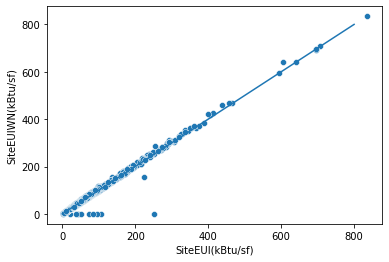

In [25]:
## Site EUI
sns.scatterplot(x = dt['SiteEUI(kBtu/sf)'], y = dt['SiteEUIWN(kBtu/sf)'])
sns.lineplot(x = [0, 800], y = [0, 800])

# Highly correlated
# Some weird points : when the WN variable is zero whereas the other is not (probably errors)
# Remove the WN feature

print(dt[ ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)'] ].corr())
dt.drop(columns = 'SiteEUIWN(kBtu/sf)', inplace = True)

_Site SourceEUI(kBtu/sf)_

                      SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)
SourceEUI(kBtu/sf)              1.000000              0.993573
SourceEUIWN(kBtu/sf)            0.993573              1.000000


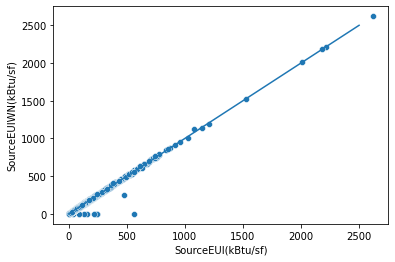

In [26]:
## Site SourceEUI(kBtu/sf)
sns.scatterplot(x = dt['SourceEUI(kBtu/sf)'], y = dt['SourceEUIWN(kBtu/sf)'])
sns.lineplot(x = [0, 2500], y = [0, 2500])

# Idem
print(dt[ ['SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)'] ].corr())
dt.drop(columns = 'SourceEUIWN(kBtu/sf)', inplace = True)

_SiteEnergyUse(kBtu)_

                       SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)
SiteEnergyUse(kBtu)               1.000000               0.707859
SiteEnergyUseWN(kBtu)             0.707859               1.000000
                       SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)
SiteEnergyUse(kBtu)                1.00000                0.99943
SiteEnergyUseWN(kBtu)              0.99943                1.00000


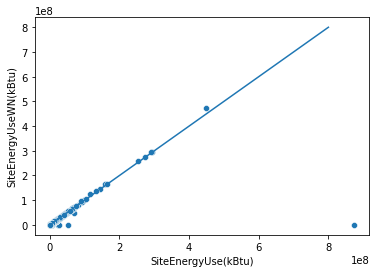

In [27]:
## Site SiteEnergyUse(kBtu)
sns.scatterplot(x = dt['SiteEnergyUse(kBtu)'], y = dt['SiteEnergyUseWN(kBtu)'])
sns.lineplot(x = [0, 8*1e8], y = [0, 8*1e8])

print(dt[ ['SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)'] ].corr())
# Some weird values : zeros for WN while >1e6 for nWN

# What if we consider case when WN is not null ?
print(dt[dt['SiteEnergyUseWN(kBtu)'] != 0][ ['SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)'] ].corr())
# Sound better, highly correlated now

# Again, drop the NW columns
dt.drop(columns = 'SiteEnergyUseWN(kBtu)', inplace = True);

_Electricity_

                   Electricity(kWh)  Electricity(kBtu)
Electricity(kWh)                1.0                1.0
Electricity(kBtu)               1.0                1.0


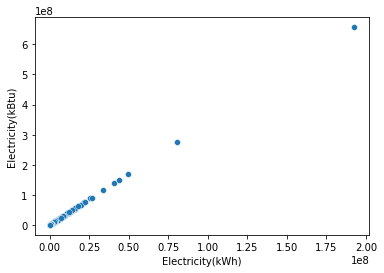

In [28]:
## Electricity - two units - metric system ! ^^
sns.scatterplot(x = dt['Electricity(kWh)'], y = dt['Electricity(kBtu)'])

# Highly correlated, keep only one (kBtu because some other features are also used that metric)
print(dt[ ['Electricity(kWh)', 'Electricity(kBtu)'] ].corr())
dt.drop(columns = 'Electricity(kWh)', inplace = True)

_Natural Gas_

                    NaturalGas(therms)  NaturalGas(kBtu)
NaturalGas(therms)                 1.0               1.0
NaturalGas(kBtu)                   1.0               1.0


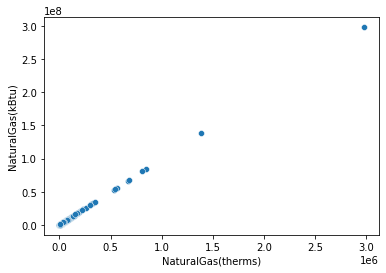

In [29]:
## Natural Gas - same as electricity
sns.scatterplot(x = dt['NaturalGas(therms)'], y = dt['NaturalGas(kBtu)'])

# Highly correlated, keep only one
print(dt[ ['NaturalGas(therms)', 'NaturalGas(kBtu)'] ].corr())
dt.drop(columns = 'NaturalGas(therms)', inplace = True)

_GHGEmissions_

                                   GHGEmissions(MetricTonsCO2e)  \
GHGEmissions(MetricTonsCO2e)                            1.00000   
GHGEmissionsIntensity(kgCO2e/ft2)                       0.46544   

                                   GHGEmissionsIntensity(kgCO2e/ft2)  
GHGEmissions(MetricTonsCO2e)                                 0.46544  
GHGEmissionsIntensity(kgCO2e/ft2)                            1.00000  


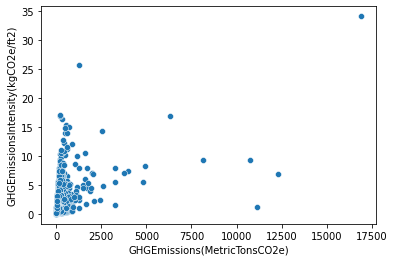

In [30]:
## GHGEmissions(MetricTonsCO2e) - one normalized by surface
sns.scatterplot(x = dt['GHGEmissions(MetricTonsCO2e)'], y = dt['GHGEmissionsIntensity(kgCO2e/ft2)'])
print(dt[ ['GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)'] ].corr())

           Emissions  Rescaled
Emissions   1.000000  0.999928
Rescaled    0.999928  1.000000


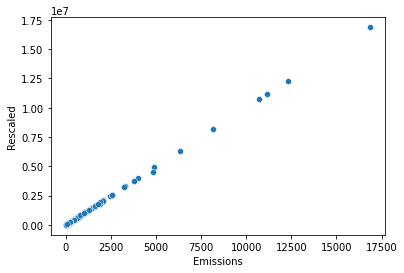

In [31]:
# If rescaled by surface :
dt_tmp = pd.DataFrame({'Emissions' : dt['GHGEmissions(MetricTonsCO2e)'],
                       'Rescaled' : dt['GHGEmissionsIntensity(kgCO2e/ft2)'] * dt['PropertyGFATotal']})
sns.scatterplot(x = dt_tmp['Emissions'], y = dt_tmp['Rescaled'])
print(dt_tmp.corr())

# Ok. Keep only the absolute GHG Emissions
dt.drop(columns = 'GHGEmissionsIntensity(kgCO2e/ft2)', inplace = True)

_OtherFuelUse_

In [32]:
Counter(dt['OtherFuelUse(kBtu)'])

# Not very informative. To drop (in addition, when kept, sum(energy) != siteEnergyUse... )
dt.drop(columns = 'OtherFuelUse(kBtu)', inplace = True)

#### Check among Property Type columns relationships

Let's try understanding among-columns relationships.

##### __AREA features__ relationships

=== Sum of GFA for I/II/III pty should sum to total GFA (or less if other pty used not accounted for) ===
That's true in 43 % of cases...
=> % diff with sum above expected GFA
Differences above 0% : 24.71 %
Differences above 1.0% : 20.52 %
Differences above 2.5% : 17.87 %
Differences above 5.0% : 14.71 %
Differences above 10.0% : 11.16 %
Differences above 25.0% : 6.71 %
Differences above 50.0% : 3.29 %


<AxesSubplot:ylabel='Count'>

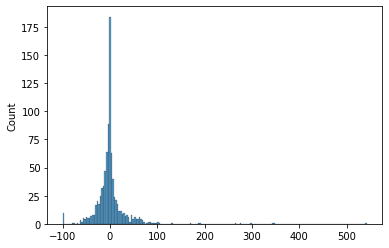

In [33]:
# PropertyGFATotal = PropertyGFAParking + PropertyGFABuilding(s) => ok.
all(dt['PropertyGFATotal'] == dt['PropertyGFAParking'] + dt['PropertyGFABuilding(s)'])

# print([(k, v) for (k,v) in enumerate(dt.columns)])

print("=== Sum of GFA for I/II/III pty should sum to total GFA (or less if other pty used not accounted for) ===")
# sum of Largest/Second/Third property use type GFA = total GFA
equality = np.mean(dt.loc[:,['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']].apply(pd.DataFrame.sum, axis = 1) == dt.loc[:,'PropertyGFATotal'])
print("That's true in {:.0f} % of cases...".format(equality*100))
# Not exactly...

# Let's see whether differences are large or no (as a variatian coeff.)
area_diffs = (dt.loc[:,['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']].apply(pd.DataFrame.sum, axis = 1) - dt.loc[:,'PropertyGFATotal']) / dt.loc[:,'PropertyGFATotal'] 

print("=> % diff with sum above expected GFA")
for pct in [0, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]:
    print("Differences above {}% : {:.2f} %".format(pct*100,np.mean((area_diffs) > pct)*100))

sns.histplot(x = area_diffs[area_diffs!=0]*100)

For some reasons, the sum(GFA) on different property use is not equal to total GFA - quite problematic especially since sum(GFA) > totalGFA.

We do not have enough information to correct that. So, let's forget about using these GFA data, we are only going to keep the totalGFA + buildingGFA, and not using Second/Third pty types.

In [34]:
dt.drop(columns = ['LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
                   'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
                   'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'], inplace = True)

##### Correlation among GFA

GFA total is strongly correlated to GFA Building(s). Let's compute a proportion of Buildings instead to decorrelate them.

                        PropertyGFATotal  PropertyGFAParking  \
PropertyGFATotal                1.000000            0.380143   
PropertyGFAParking              0.380143            1.000000   
PropertyGFABuilding(s)          0.989948            0.245507   

                        PropertyGFABuilding(s)  
PropertyGFATotal                      0.989948  
PropertyGFAParking                    0.245507  
PropertyGFABuilding(s)                1.000000  
          prop      true
prop  1.000000 -0.365497
true -0.365497  1.000000


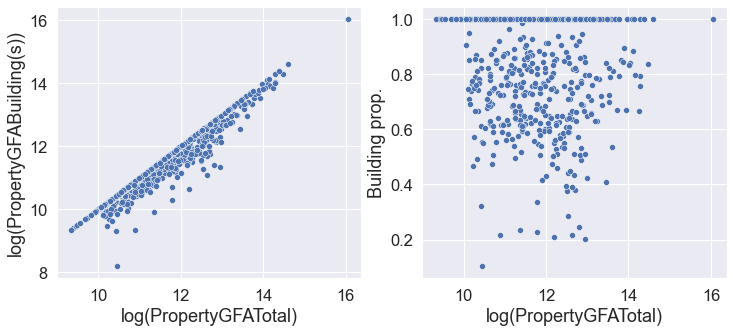

In [35]:
print(dt.loc[:,['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)']].corr())

sns.set(rc = {'figure.figsize':(12,5)}, font_scale = 1.5)
fig, ax = plt.subplots(1,2)
p=sns.scatterplot(y=np.log(dt['PropertyGFABuilding(s)']), x=np.log(dt['PropertyGFATotal']), ax = ax[0]) 
p.set_ylabel('log(PropertyGFABuilding(s))')
p.set_xlabel('log(PropertyGFATotal)')

p=sns.scatterplot(y=dt['PropertyGFABuilding(s)'] / dt['PropertyGFATotal'], x=np.log(dt['PropertyGFATotal']), ax = ax[1]) 
p.set_ylabel('Building prop.')
p.set_xlabel('log(PropertyGFATotal)')

print(pd.DataFrame({'prop' : dt['PropertyGFABuilding(s)'] / dt['PropertyGFATotal'], 
              'true' : np.log(dt['PropertyGFATotal'])}).corr())

dt['PropertyGFABuildings_prop'] = dt['PropertyGFABuilding(s)'] / dt['PropertyGFATotal']

##### Check the property types

In [36]:
Counter(dt.PrimaryPropertyType).most_common()

[('Small- and Mid-Sized Office', 281),
 ('Other', 250),
 ('Warehouse', 184),
 ('Large Office', 164),
 ('Mixed Use Property', 114),
 ('Retail Store', 86),
 ('Hotel', 74),
 ('Worship Facility', 70),
 ('Distribution Center', 53),
 ('K-12 School', 51),
 ('Medical Office', 42),
 ('Supermarket / Grocery Store', 39),
 ('Self-Storage Facility', 28),
 ('University', 24),
 ('Residence Hall', 21),
 ('Senior Care Community', 20),
 ('Refrigerated Warehouse', 12),
 ('Restaurant', 12),
 ('Hospital', 10),
 ('Laboratory', 10),
 ('Non-Refrigerated Warehouse', 2),
 ('Low-Rise Multifamily', 2),
 ('Restaurant\n', 1)]

In [37]:
# 2x Low-Rise Multifamily should not be here, to drop
# Restaurant\n : typo, renamed.

dt = dt[dt.PrimaryPropertyType != "Low-Rise Multifamily"].reset_index(drop=True).copy()
dt.PrimaryPropertyType.replace({'Restaurant\n' : 'Restaurant'}, inplace = True)

For the others, let's create broader categories

In [38]:
maps = { 'Small- and Mid-Sized Office' : 'Offices',
         'Large Office' : 'Offices',
         'Mixed Use Property' : 'Mixed Use Property', # ? to keep
         'Retail Store' : 'Commercial',
         'Distribution Center' : 'Commercial',
         'Supermarket / Grocery Store' : 'Commercial',
         'K-12 School' : 'Education',
         'University' : 'Education',
         'Residence Hall' : 'Education', # Chambres étudiantes
         'Medical Office' : 'Medical',
         'Senior Care Community' : 'Medical',
         'Hospital' : 'Medical',
         'Hotel' : 'Hotel',
         'Laboratory' : 'Laboratory', 
         'Worship Facility' : 'Worship Facility',
         'Warehouse' : 'Warehouse',
         'Self-Storage Facility' : 'Warehouse',
         'Non-Refrigerated Warehouse' : 'Warehouse',
         'Refrigerated Warehouse' : 'Refrigerated Warehouse',
         'Restaurant' : 'Restaurant',
         'Others' : 'Others'} 

dt.PrimaryPropertyType.replace(maps, inplace = True)

Counter(dt.PrimaryPropertyType).most_common()

[('Offices', 445),
 ('Other', 250),
 ('Warehouse', 214),
 ('Commercial', 178),
 ('Mixed Use Property', 114),
 ('Education', 96),
 ('Hotel', 74),
 ('Medical', 72),
 ('Worship Facility', 70),
 ('Restaurant', 13),
 ('Refrigerated Warehouse', 12),
 ('Laboratory', 10)]

#### Check among Energy columns relationships

In [39]:
# Energy/GHG must always be >= 0 : let's check.
all_above_zero = np.apply_along_axis(all, 1, np.array(dt.loc[:, ['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
                                                                  'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
                                                                  'Electricity(kBtu)', 'NaturalGas(kBtu)',
                                                                  'GHGEmissions(MetricTonsCO2e)']] >= 0))
np.where(~ all_above_zero ) # ok.

# if needed
# dt = dt[all_above_zero].reset_index(drop=True)

(array([], dtype=int64),)

In [40]:
# Check sum are ok (compute CV)
diff_dist = (np.array(dt.loc[:,['SteamUse(kBtu)','Electricity(kBtu)', 'NaturalGas(kBtu)']].apply(pd.DataFrame.sum, axis = 1)) - dt['SiteEnergyUse(kBtu)']) / dt['SiteEnergyUse(kBtu)']

np.mean(np.abs(diff_dist) > 0.01)

0.012919896640826873

One can assume sum are ok (i.e. less than 1 % difference in 99% of cases).

In addition, from data, we can say that : 

    + SiteEnergyUse (kBtu) = sum(Steam, Electricity, Natural Gas) 
    + SiteEUI (kBtu/sf) = SiteEnergyUse (kBtu) / PropertyGFABuilding
    

The idea of the project is to be able to predict EnergyUse & GHGEmission without using annual reports (i.e. w/o using data on Steam/Elec./Gas use). Nevertheless, one possibility is to compute an _Energy Mix_ new feature (i.e. proportion of each energy for a building) - as such, a new building, without report, can still give the relative proportion of their energy sources (i.e. the energy mix they use). In all cases, models w/ or w/o will be build after. 

In [42]:
total_energy = np.array(dt.loc[:,['SteamUse(kBtu)','Electricity(kBtu)', 'NaturalGas(kBtu)']].apply(pd.DataFrame.sum, axis = 1))

dt["Steam_prop"] = np.divide(np.array(dt.loc[:,['SteamUse(kBtu)']]).reshape(-1), total_energy)
dt["Electricity_prop"] = np.divide(np.array(dt.loc[:,['Electricity(kBtu)']]).reshape(-1), total_energy)
dt["Gas_prop"] = np.divide(np.array(dt.loc[:,['NaturalGas(kBtu)']]).reshape(-1), total_energy)

<AxesSubplot:xlabel='Electricity_prop'>

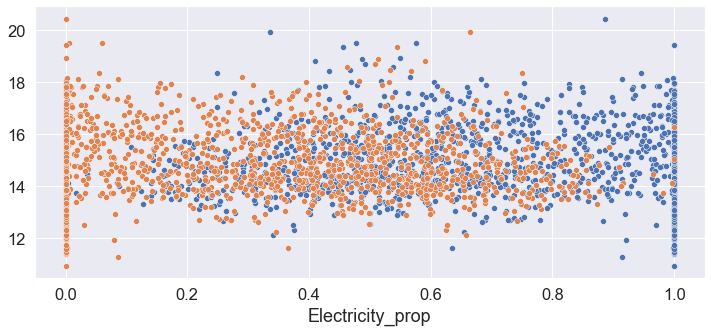

In [43]:
sns.scatterplot(x=dt["Electricity_prop"], y=np.log(total_energy))
sns.scatterplot(x=dt["Gas_prop"], y=np.log(total_energy))

<AxesSubplot:xlabel='Electricity_prop', ylabel='GHGEmissions(MetricTonsCO2e)'>

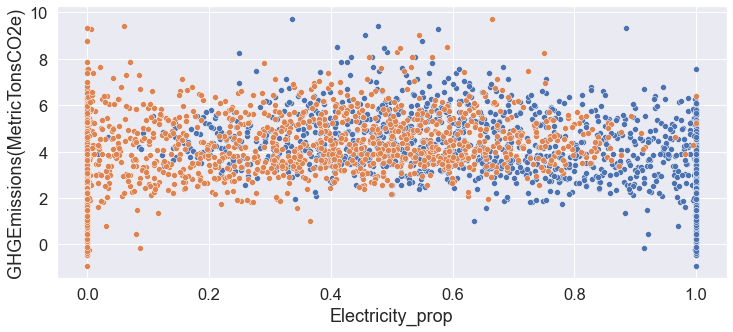

In [45]:
sns.scatterplot(x=dt["Electricity_prop"], y=np.log(dt['GHGEmissions(MetricTonsCO2e)']))
sns.scatterplot(x=dt["Gas_prop"], y=np.log(dt['GHGEmissions(MetricTonsCO2e)']))

In [44]:
dt.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'PropertyGFABuildings_prop', 'Steam_prop', 'Electricity_prop',
       'Gas_prop'],
      dtype='object')

### How to use geographical data ?

We kept the lat/long positions of buildings : one might assume that their positions in the city could help predicting Energy/GHG, let's compute a simple index : the distance to the city center (underlying idea, city center => older => less isolated but more renovated?)

<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

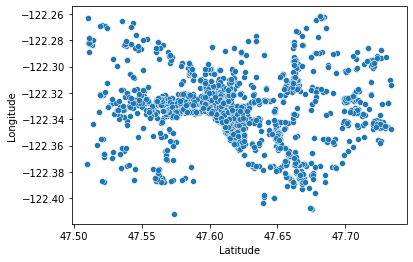

In [44]:
## Spatial position might also help ? No sure spatial autocorr. can be easily be considered with python (using e.g. Matern cov. structure, will see)
sns.scatterplot(x = dt.Latitude, y = dt.Longitude)

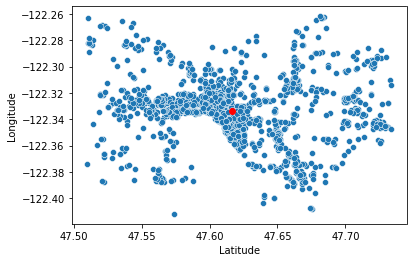

In [45]:
# Compute and add centroid
centroid = (np.mean(dt.Latitude), np.mean(dt.Longitude))

sns.scatterplot(x = dt.Latitude, y = dt.Longitude)
plt.scatter(x=centroid[0], y=centroid[1], color='r')

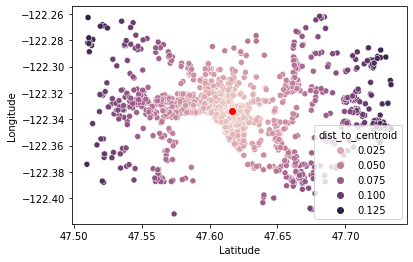

In [46]:
# Add distance-to-centroid feature
dt['dist_to_centroid'] = np.sqrt((dt.Latitude - centroid[0])**2 + (dt.Longitude - centroid[1])**2)
sns.scatterplot(x = dt.Latitude, y = dt.Longitude, hue = dt['dist_to_centroid'])
plt.scatter(x=centroid[0], y=centroid[1], color='r')

### Last columns clean before analysis

In [47]:
dt.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'PropertyGFABuildings_prop', 'Steam_prop', 'Electricity_prop',
       'Gas_prop', 'dist_to_centroid'],
      dtype='object')

In [48]:
# We keep only usefull feature for analysis - removing Neighboorhood as redundant with Council District Code
subset = ['PrimaryPropertyType', 'CouncilDistrictCode', 'dist_to_centroid', \
          'YearBuilt',
          'PropertyGFATotal', 'PropertyGFABuildings_prop',
          'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',\
          'Steam_prop', 'Electricity_prop','Gas_prop']

dt_clean = dt.loc[:,subset]

dt_clean.to_csv('./data/for_prediction.csv', index = False)